In [ ]:
!pip install pytorch_lightning

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import random
import cv2
import pickle as pkl

from torch import nn, optim
from torch import functional as F
from torchvision import models
from pathlib import Path
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from functools import partial
import pytorch_lightning as pl

from collections import defaultdict

In [ ]:
torch.__version__

'1.9.0+cu102'

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(47)

In [ ]:
!unzip /content/gdrive/MyDrive/ISSonDL2021_Challenge/issondl_challenge_dataset.zip

In [ ]:
dataset_path = Path('/content', 'dataset')
train_path = dataset_path / 'TRAIN'
test_path = dataset_path / 'TEST'
organic_foldername = 'O'
recyclable_foldername = 'R'

BATCH_SIZE = 64
EPOCHS = 10

Norganic: 12565
Nrecyclable: 9999


Text(0.5, 1.0, 'Train labels distribution')

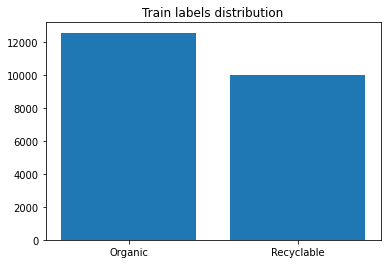

In [ ]:
organic_files = [str(x) for x in (train_path / organic_foldername).iterdir() if x.is_file()]
norganic = len(organic_files)
recyclable_files = [str(x) for x in (train_path / recyclable_foldername).iterdir() if x.is_file()]
nrecyclable = len(recyclable_files)
print(f'Norganic: {norganic}')
print(f'Nrecyclable: {nrecyclable}')

def split(*lists, seed=47, test_perc=.25):
  r = random.Random(seed)
  res = []
  for l in lists:
    r.shuffle(l)
    test_size = int(len(l) * test_perc)
    train_size = len(l) - test_size
    train, test = l[:train_size], l[-test_size:]
    assert len(l) == len(train) + len(test)
    res.append((train, test))
  return res

organic_tuple, recyclable_tuple = split(organic_files, recyclable_files, seed=47, test_perc=.25)
organic_train, organic_validation = organic_tuple
recyclable_train, recyclable_validation = recyclable_tuple

plt.figure()
plt.bar([0, 1], [norganic, nrecyclable], tick_label=['Organic', 'Recyclable'])
plt.title('Train labels distribution')

In [ ]:
class ImageLoader(Dataset):
  def __init__(self, path, transform):
    self.path = path
    self.transform = transform
    self.all_images = [x for x in os.listdir(path) if os.path.isfile(os.path.join(path, x))]

  def __len__(self):
    return len(self.all_images)

  def __getitem__(self, idx):
    path = os.path.join(self.path, self.all_images[idx])
    image = Image.open(path).convert('RGB')
    tensor_image = self.transform(image) if self.transform else image

    filename = os.path.splitext(self.all_images[idx])[0]
    return filename, tensor_image

In [ ]:
train_transformers = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAutocontrast(),
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])
test_transformers = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

def file_validator(filepath, checklist):
  return filepath in checklist

def get_files(*lists):
  # Generate a single list containing all the elements
  starter = lists[0].copy()
  for l in lists[1:]:
    starter.extend(l)
  return starter

  
train_list = get_files(organic_train, recyclable_train)
validation_list = get_files(organic_validation, recyclable_validation)

assert len(set(train_list).intersection(set(validation_list))) == 0

train_validator = partial(file_validator, checklist=set(train_list))
validation_validator = partial(file_validator, checklist=set(validation_list))

train_dataset = ImageFolder(train_path, transform=train_transformers, is_valid_file=train_validator)
validation_dataset = ImageFolder(train_path, transform=test_transformers, is_valid_file=validation_validator)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=2)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=2)

assert len(train_dataset) == len(train_list)
assert len(validation_list) == len(validation_dataset)

print(len(train_dataset))
print(len(validation_dataset))

16924
5640


In [ ]:
test_dataset = ImageLoader(test_path, test_transformers)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=1, drop_last=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


test max: 0.9764705896377563, min: -1.0
train max: 1.0, min: -1.0


Text(0.5, 1.0, '0')

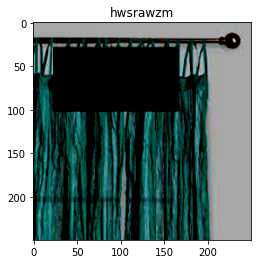

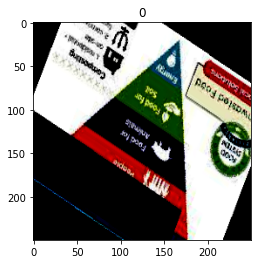

In [ ]:
p, test_image = test_dataset[432]
train_image, train_label = train_dataset[0]

test_npy = test_image.cpu().numpy()
train_npy = train_image.cpu().numpy()

print(f'test max: {test_npy.max()}, min: {test_npy.min()}')
print(f'train max: {train_npy.max()}, min: {train_npy.min()}')

plt.figure()
plt.imshow(test_npy.transpose((1, 2, 0)), vmin=-1, vmax=1)
plt.title(p)

plt.figure()
plt.imshow(train_npy.transpose((1, 2, 0)), vmin=-1, vmax=1)
plt.title(train_label)

In [ ]:
class LightningWrapper(pl.LightningModule):
  def __init__(self, model):
    super().__init__()
    self.model = model
    self.loss = nn.BCEWithLogitsLoss()
    self.val_numerator = 0
    self.val_denominator = 0
    self.mylogs = defaultdict(list)
    self.loss_accumulator = 0
    self.batch_counter = 0

  def forward(self, x):
    pred = self.model(x)
    return pred

  def configure_optimizers(self):
    optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    x, y = train_batch
    y = y.float()
    pred = self.model(x).squeeze()
    loss = self.loss(pred, y)
    self.log('train_loss_per_step', loss)

    self.mylogs['train_loss_per_step'].append(loss)

    self.loss_accumulator += loss
    self.batch_counter += 1
    return loss

  def training_epoch_end(self, training_step_outputs):
    self.mylogs['my_train_loss_avg'].append(self.loss_accumulator / self.batch_counter)
    self.batch_counter = 0
    self.loss_accumulator = 0
    return

  def validation_step(self, validation_batch, batch_idx):
    x, y = validation_batch
    y = y.float()
    pred = self.model(x).squeeze()

    pred_npy = (torch.sigmoid(pred) >= 0.5).cpu().numpy()
    y_npy = y.cpu().numpy()
    self.val_numerator += (pred_npy == y_npy).sum()
    self.val_denominator += y_npy.size
    
    loss = self.loss(pred, y)
    self.log('validation_loss', loss)
    self.mylogs['validation_loss'].append(loss)
    return

  def validation_step_end(self, batch_parts):
    accuracy = self.val_numerator / self.val_denominator
    self.val_numerator = 0
    self.val_denominator = 0
    self.log('validation_accuracy', accuracy)
    self.mylogs['validation_accuracy'].append(accuracy)
    return

  def backward(self, loss, optimizer, optimizer_idx):
    loss.backward()

In [ ]:
net = models.densenet121(pretrained=True)
for p in net.parameters():
  p.requires_grad = False
net.classifier = nn.Sequential(
      nn.Linear(1024, 512),
      nn.LeakyReLU(),
      nn.Dropout(0.2),
      nn.Linear(512, 1)
)#nn.Linear(1024, 1)

pl_net = LightningWrapper(net)
trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=1, gpus=1)
trainer.fit(pl_net, train_loader, validation_loader)
torch.save(pl_net.model, '/content/gdrive/MyDrive/ISSonDL2021_Challenge/densenet121.pt')

logger_info = dict(pl_net.mylogs)
with open('/content/gdrive/MyDrive/ISSonDL2021_Challenge/densenet_512_log.pkl', 'wb') as fp:
  pkl.dump(logger_info, fp)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name  | Type              | Params
--------------------------------------------
0 | model | DenseNet          | 7.5 M 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
525 K     Trainable params
7.0 M     Non-trainable params
7.5 M     Total params
29.917    Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:373: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f"Your {mode}_dataloader has `shuffle=True`, it is best practice to turn"
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
pl_net.model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

Accuracy: 0.9464539007092199


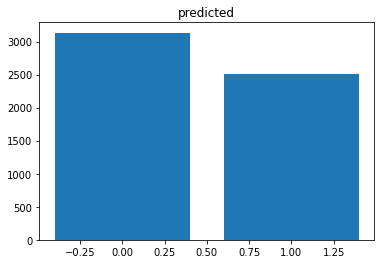

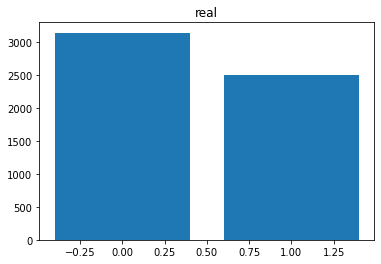

In [ ]:
def count_class_values(arr):
  cls0 = (arr == 0).sum()
  cls1 = (arr == 1).sum()
  return cls0, cls1

num = 0
den = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = pl_net.model
# with open('/content/gdrive/MyDrive/ISSonDL2021_Challenge/densenet_256.pt', 'rb') as fp:
#   model = torch.load(fp)

model = model.to(device)
pred_distrib = [0, 0]
real_distrib = [0, 0]
pred_list = []
gt_list = []
with torch.no_grad():
  model.eval()
  for val_batch in validation_loader:
    x, y = val_batch
    x = x.to(device)

    y_npy = y.cpu().numpy()
    real0, real1 = count_class_values(y_npy)
    real_distrib[0] += real0
    real_distrib[1] += real1

    pred = model(x)
    pred_discr = (torch.sigmoid(pred) >= 0.5).squeeze()
    pred_npy = pred_discr.cpu().numpy().astype(np.int)
    pred0, pred1 = count_class_values(pred_npy)
    pred_distrib[0] += pred0
    pred_distrib[1] += pred1

    pred_list.append(pred_npy)
    gt_list.append(y_npy.flatten())

    mask_increment = (pred_npy == y_npy).sum()
    assert mask_increment <= y_npy.size
    num += mask_increment
    den += y_npy.size

acc = num / den
print(f'Accuracy: {acc}')

pred_npy = np.concatenate(pred_list)
gt_npy = np.concatenate(gt_list)

# f1_compute = f1_score(gt_npy, pred_npy, average=None, labels=[0, 1])
# print(f'F1 scores: {f1_compute}')

plt.figure()
plt.bar([0, 1], pred_distrib)
plt.title('predicted')

plt.figure()
plt.bar([0, 1], real_distrib)
plt.title('real')

logger_info['validation_accuracy_final'] = acc
with open('/content/gdrive/MyDrive/ISSonDL2021_Challenge/densenet_512_log2.pkl', 'wb') as fp:
  pkl.dump(logger_info, fp)

In [ ]:
# TRAIN ON THE ENTIRE DATASET
all_train_dataset = ImageFolder(train_path, transform=train_transformers)
all_train_loader = DataLoader(all_train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

net_all = models.densenet121(pretrained=True)
for p in net_all.parameters():
  p.requires_grad = False
net_all.fc = #nn.Sequential([
      nn.Linear(1024, 512),
      nn.LeakyReLU(),
      nn.Dropout(0.2),
      nn.Linear(512, 1)
])#nn.Linear(1024, 1)

pl_net_all = LightningWrapper(net_all)
trainer = pl.Trainer(max_epochs=10, gpus=1)
trainer.fit(pl_net_all, all_train_loader)
# torch.save(pl_net_all.model, '/content/gdrive/MyDrive/ISSonDL2021_Challenge/densenet121_final.pt')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f'you defined a {step_name} but have no {loader_name}. Skipping {stage} loop')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | ResNet            | 11.2 M
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
513       Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)


In [ ]:
!unzip /content/gdrive/MyDrive/ISSonDL2021_Challenge/dataset_stage_2.zip

In [ ]:
# TEST FOR ROUND 2

test_transformers = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

test_path2 = Path('/content', 'dataset_stage_2')
test_dataset = ImageLoader(test_path2, test_transformers)

res_df = defaultdict(list)
# 'id', 'label'
res_df_export_path = '/content/gdrive/MyDrive/ISSonDL2021_Challenge/densenet121_512_final_submission_step2.csv'

final_model = pl_net_all.model.to(device)
class_to_idx = all_train_dataset.class_to_idx
print(f'class_to_idx: {class_to_idx}')
conversion_dict = {class_to_idx[k]: k for k in class_to_idx}
print(f'conversion dict: {conversion_dict}')
with torch.no_grad():
  final_model.eval()
  for idx in range(len(test_dataset)):
    identifier, x = test_dataset[idx]
    x = x.unsqueeze(0).to(device)

    pred = final_model(x)
    pred_sigm = torch.sigmoid(pred)
    pred_class = (pred_sigm >= 0.5).squeeze(0).cpu().numpy()
    assert len(pred_class) == 1
    pred_class = pred_class[0]
    if pred_class:
      pred_class = 1
    else:
      pred_class = 0

    pred_class_str = conversion_dict[pred_class]
    res_df['id'].append(identifier)
    res_df['label'].append(pred_class_str)

df = pd.DataFrame(res_df)
df.to_csv(res_df_export_path, index=False)